# Evaluations: One-Electron Reduced Density Matrix (1RDM) Related Properties

Besides the electron density ($\rho(r)$), the 1RDM  $\gamma(\mathbf{r}_1, \mathbf{r}_2)$ is another quantity with a one-to-one correspondence to the ground state wavefunction $\Psi_0$ of a many-electron system. Because of this, the 1RDM is also useful in the development of Density Functional Theory density functionals.

Given the 1RDM of a system expanded in a basis of spin orbitals $\{\phi_i(\mathbf{r})\}$:

$$
\begin{equation*}
  \gamma(\mathbf{r}_1, \mathbf{r}_2) = \sum_{ij} \gamma_{ij} \phi_i(\mathbf{r}_1) \phi_j(\mathbf{r}_2)
\end{equation*}
$$

[`gbasis`](http://gbasis.qcdevs.org/intro.html)  supports the evaluation of several local ($\mathbf{r} = \mathbf{r'}$) properties that depend on the local derivatives of the 1RDM :

$$
\begin{equation*}
  \left.
    \frac{\partial^{p_x + p_y + p_z}}{\partial x_1^{p_x} \partial y_1^{p_y} \partial z_1^{p_z}}
    \frac{\partial^{q_x + q_y + q_z}}{\partial x_2^{q_x} \partial y_2^{q_y} \partial z_2^{q_z}}
    \gamma(\mathbf{r}_1, \mathbf{r}_2)
  \right|_{\mathbf{r}_1 = \mathbf{r}_2 = \mathbf{r}_n} =
  \left.
    \frac{\partial^{q_x + q_y + q_z}}{\partial x_1^{q_x} \partial y_1^{q_y} \partial z_1^{q_z}}
    \frac{\partial^{p_x + p_y + p_z}}{\partial x_2^{p_x} \partial y_2^{p_y} \partial z_2^{p_z}}
    \gamma(\mathbf{r}_1, \mathbf{r}_2)
  \right|_{\mathbf{r}_1 = \mathbf{r}_2 = \mathbf{r}_n}
\end{equation*}
$$

The following examples show the different supported 1RDM properties and how to evaluate them using `gbasis`.


## Load Data

To evaluate properties dependent on the system state, we need its wavefunction or an equivalent representation. In `gbasis`, this is done through the **one-electron reduced density matrix** (1-RDM). As a case example, the following code will load this data from a `fchk` file corresponding to a `ub3lyp/aug-cc-pvtz` calculation on ethylene. The file can be [downloaded]() from the data folder of this repository. For simplicity, we will be using the [`iodata`](https://iodata.readthedocs.io/en/latest/) package to load the data:

In [1]:
import numpy as np
from iodata import load_one
from gbasis.wrappers import from_iodata

# formchk file available from
#

# load molecule info and basis from fchk file
mol_data = load_one("C2H4_hf_ccpvdz.fchk")
ao_basis = from_iodata(mol_data)  # basis definition for the atomic orbitals

# one electron RDM from fchk file
rdm = mol_data.one_rdms["scf"]

# atomic coordinates and numbers
atcoords = mol_data.atcoords
atnums = mol_data.atnums

print(f"Loaded: {mol_data.title}")
print(f"Basis: {mol_data.obasis_name}")
print(f"Atom numbers: {mol_data.atnums}")
print(f"Atom coordinates:\n{mol_data.atcoords}")
print(f"Molecule is planar: {np.allclose(atcoords[:, 0], 0 , atol=1e-6)}") # atoms in yz plane
print(f"Number of atomic orbitals: {len(ao_basis)}")
print(f"One electron RDM shape: {rdm.shape}")

Loaded: C2H4_cc-pvdz
Basis: cc-pvdz
Atom numbers: [6 1 1 6 1 1]
Atom coordinates:
[[-1.41331444e-15 -8.50766406e-17  1.24804461e+00]
 [ 3.21359945e-15  1.74354670e+00  2.32302264e+00]
 [-9.10524186e-15 -1.74354670e+00  2.32302264e+00]
 [ 2.05009465e-15  1.68343367e-16 -1.24804461e+00]
 [-2.94318351e-15 -1.74354670e+00 -2.32302264e+00]
 [ 9.66014602e-15  1.74354670e+00 -2.32302264e+00]]
Molecule is planar: True
Number of atomic orbitals: 24
One electron RDM shape: (48, 48)


## Define Auxiliary Grid

The loaded system is planar and all of its atoms lie on the yz plane (x=0) in this specific file. For simplicity, we will perform all successive analysis on the yz plane. 

In [2]:
# Sample n points uniformly along x and y axes within [-coord_limit, coord_limit]
coord_limit = 5
plt_pts = 40
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
y_vals = np.linspace(-coord_limit, coord_limit, plt_pts)
z_vals = y_vals

# Sample 3D points uniformly in the molecular yz-plane (x=0)
y_vals, z_vals = np.meshgrid(y_vals, z_vals)
y_vals, z_vals = y_vals.flatten(), z_vals.flatten()
x_vals = np.zeros_like(y_vals)
points = np.array([x_vals, y_vals, z_vals]).T # gbasis evaluates at 3D points

print("Grid for evaluating the density matrix has shape: ", points.shape)
print(f"Distance between grid points: {2*coord_limit/(plt_pts-1)}")


Grid for evaluating the density matrix has shape:  (1600, 3)
Distance between grid points: 0.2564102564102564


## Positive Definite Kinetic Energy Density

The positive definite kinetic energy density is defined as the sum of the diagonal elements of the kinetic energy density matrix.

$$
\begin{align*}
t_+ (\mathbf{r}_n)
        &= \frac{1}{2} \left.
          \nabla_{\mathbf{r}} \cdot \nabla_{\mathbf{r}'} \gamma(\mathbf{r}, \mathbf{r}')
        \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
        &= \frac{1}{2} \left(
          \frac{\partial^2}{\partial x \partial x'} \gamma(\mathbf{r}, \mathbf{r}')
          + \frac{\partial^2}{\partial y \partial y'} \gamma(\mathbf{r}, \mathbf{r}')
          + \frac{\partial^2}{\partial z \partial z'} \gamma(\mathbf{r}, \mathbf{r}')
        \right)_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}
\end{align*}
$$

This is a property commonly used in conceptual density functional theory. It can be evaluated using the [`evaluate_positive_definite_kinetic_energy`](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=evaluate_density#gbasis.evals.density.evaluate_posdef_kinetic_energy_density) function closely related is the [general kinetic energy density](http://gbasis.qcdevs.org/_autosummary/gbasis.evals.html?highlight=kinetic#gbasis.evals.density.evaluate_general_kinetic_energy_density).

$$t_{\alpha} (\mathbf{r}_n) = t_+(\mathbf{r}_n) + \alpha \nabla^2 \rho(\mathbf{r}_n)$$

 which can be evaluated in a similar way.
 
 The following example shows how to evaluate the positive definite kinetic energy density and plot it on the molecular plane. The positive definite kinetic energy density is represented as a scalar field, where the color represents the magnitude of the positive definite kinetic energy density.

The kinetic energy density has shape (1600,) (one value per point)
The kinetic energy density is positive definite: True


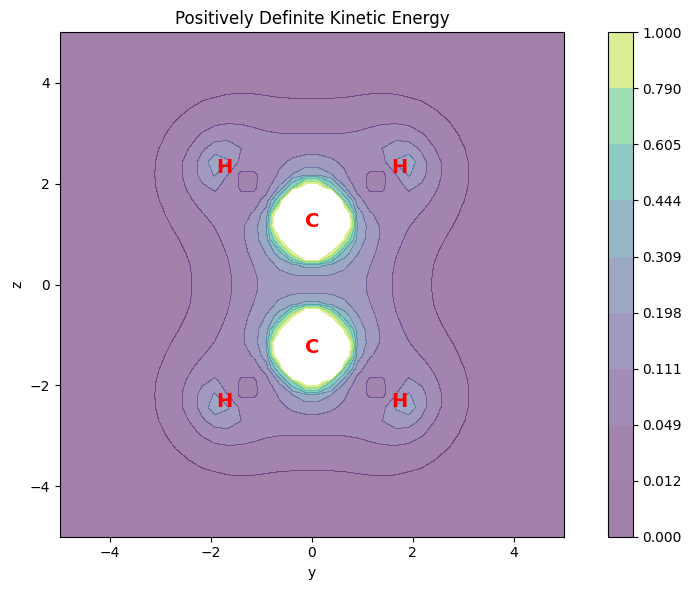

In [3]:
import matplotlib.pyplot as plt
from gbasis.evals.density import evaluate_posdef_kinetic_energy_density


# Compute expected electron density using GBasis
k_vals = evaluate_posdef_kinetic_energy_density(rdm, ao_basis, points)

print(f"The kinetic energy density has shape {k_vals.shape} (one value per point)")
print(f"The kinetic energy density is positive definite: {np.all(k_vals >= 0)}")

# plot the electron density
fig=plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect='equal')
# Plot the electron density as contour plot
ax1.set_title("Positively Definite Kinetic Energy")
ax1.set_xlabel("y")
ax1.set_ylabel("z")

X = points[:, 1].reshape(plt_pts, plt_pts)
Y = points[:, 2].reshape(plt_pts, plt_pts)
Z = k_vals.reshape(plt_pts, plt_pts)
# Add contour plot of the electron density
plt.contourf(X, Y, Z, 10, cmap='viridis', alpha=0.5, levels=np.linspace(0, 1, 10) ** 2, vmin=0, vmax=1)
plt.colorbar()

# Add atomic symbols to the plots
symbols = ['C', 'H', 'H', 'C', 'H', 'H']
yz_coords = atcoords[:, 1:]
for coord, symbol in zip(yz_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Stress Tensor

The stress tensor is defined as:

$$
\begin{equation}
    \boldsymbol{\sigma}_{ij}(\mathbf{r}_n | \alpha, \beta) = - \alpha \left.  \frac{\partial^2}{\partial r_i \partial r'_j} \gamma(\mathbf{r}, \mathbf{r}')
    \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n} + (1 - \alpha)  \left. \frac{\partial^2}{\partial r_i \partial r_j} \gamma(\mathbf{r}, \mathbf{r})
    \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n} - \frac{1}{2} \delta_{ij} \beta \nabla^2 \rho(\mathbf{r}_n)
\end{equation}
$$

For an infinitesimal cube centered at $\mathbf{r}_n$ containing an electron density $\rho(r)dr$, the stress tensor represents the infinitesimal force acting on each face of the cube ($i$). In the following code, we will illustrate how to evaluate the stress tensor at a set of points using `gbasis`.

In [4]:
from gbasis.evals.stress_tensor import evaluate_stress_tensor

# center of mass of ethylene
com = (np.mean(mol_data.atmasses[:,None] * atcoords, axis=0) / np.sum(mol_data.atmasses))[None,:]
print(f"Center of mass of ethylene: {com}", end="\n\n")

alpha, beta = 1, 0
print(f"Stress Tensor (α = {alpha} and β = {beta}):")
st_com = evaluate_stress_tensor(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Shape of a stress tensor at one point: {st_com[0].shape}")
print(f"Stress tensor at center of mass:\n{st_com}")
print(f"Stress tensor at center of mass is zero: {np.allclose(st_com, 0)}")

alpha, beta = 0.5, 1
print("\nStress Tensor (α = 0.5 and β = 1):")
print(f"Shape of a stress tensor at one point: {st_com[0].shape}")
print(f"Stress Tensor (α = {alpha} and β = {beta}):")
st_com = evaluate_stress_tensor(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Stress tensor at center of mass:\n{st_com}")
print(f"Stress tensor at center of mass is zero: {np.allclose(st_com, 0)}")

print(f"\nStress Tensor evaluated at {points.shape[0]} points:")
ef_vals = evaluate_stress_tensor(rdm, ao_basis, points, alpha=alpha, beta=beta)
print(f"Shape of a stress tensor result: {ef_vals.shape}")

Center of mass of ethylene: [[ 5.03790449e-17  5.93301676e-18 -5.93301676e-18]]

Stress Tensor (α = 1 and β = 0):
Shape of a stress tensor at one point: (3, 3)
Stress tensor at center of mass:
[[[-1.78982437e-01 -2.25522680e-17 -4.65113556e-16]
  [-2.25522680e-17 -8.43360811e-02 -1.90819582e-17]
  [-4.65113556e-16 -1.90819582e-17 -9.37882592e-03]]]
Stress tensor at center of mass is zero: False

Stress Tensor (α = 0.5 and β = 1):
Shape of a stress tensor at one point: (3, 3)
Stress Tensor (α = 0.5 and β = 1):
Stress tensor at center of mass:
[[[ 1.84212215e-01 -1.70289590e-17 -8.97260611e-16]
  [-1.70289590e-17  2.22130118e-01 -5.61616725e-17]
  [-8.97260611e-16 -5.61616725e-17  5.63747980e-01]]]
Stress tensor at center of mass is zero: False

Stress Tensor evaluated at 1600 points:
Shape of a stress tensor result: (1600, 3, 3)


## Ehrenfest Force

The Ehrenfest force accounts for force exerted on the electron density at a point $\rho(\mathbf{r})$ by the atoms and the electron density elsewhere. It is defined as the negative of the divergence of the stress tensor:

$$
\begin{equation}
  \begin{split}
    F_{j}(\mathbf{r}_n | \alpha, \beta)
    =&
    \alpha
    \sum_i
    \left.
      \frac{\partial^3}{\partial r^2_i \partial r'_j} \gamma(\mathbf{r}, \mathbf{r}')
    \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}
    - (1 - \alpha) \sum_i
    \left.
      \frac{\partial^3}{\partial r^2_i \partial r_j} \gamma(\mathbf{r}, \mathbf{r})
    \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
    &- (1 - 2\alpha)
    \sum_i
    \left.
      \frac{\partial^3}{\partial r_i \partial r_j \partial r'_i} \gamma(\mathbf{r}, \mathbf{r})
    \right|_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}
    + \frac{1}{2} \sum_i \delta_{ij} \beta
    \frac{\partial}{\partial r_i} \nabla^2 \rho(\mathbf{r}_n)\\
  \end{split}
\end{equation}
$$

The following example shows how to evaluate it at a set of points.


In [5]:
from gbasis.evals.stress_tensor import evaluate_ehrenfest_force

# center of mass of ethylene
com = (np.mean(mol_data.atmasses[:,None] * atcoords, axis=0) / np.sum(mol_data.atmasses))[None,:]
print(f"Center of mass of ethylene: {com}", end="\n\n")

alpha, beta = 1, 0
print(f"Ehrenfest force (α = {alpha} and β = {beta}):")
ef_com = evaluate_ehrenfest_force(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest force at one point: {ef_com[0].shape}")
print(f"Ehrenfest force at center of mass:\n{ef_com}")
print(f"Ehrenfest force at center of mass is zero: {np.allclose(ef_com, 0)}")
print(f"(should be zero, it is Lorentz point)", end="\n\n")

alpha, beta = 0.5, 1
print("Ehrenfest force  (α = 0.5 and β = 1):")
ef_com = evaluate_ehrenfest_force(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest force at one point: {ef_com[0].shape}")
print(f"Ehrenfest force at center of mass:\n{ef_com}")
print(f"Ehrenfest force at center of mass is zero: {np.allclose(ef_com, 0)}")
print(f"(should be zero, it is Lorentz point)", end="\n\n")

print(f"Ehrenfest force evaluated at {points.shape[0]} points:")
ef_vals = evaluate_ehrenfest_force(rdm, ao_basis, points, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest force result: {ef_vals.shape}")
print(f"None have out of plane components: {np.allclose(ef_vals[:, 0], 0)}")
print("(should be true, yz is molecular plane)")

Center of mass of ethylene: [[ 5.03790449e-17  5.93301676e-18 -5.93301676e-18]]

Ehrenfest force (α = 1 and β = 0):
Shape of a Ehrenfest force at one point: (3,)
Ehrenfest force at center of mass:
[[-8.59906281e-17 -3.84562409e-17  1.36482419e-17]]
Ehrenfest force at center of mass is zero: True
(should be zero, it is Lorentz point)

Ehrenfest force  (α = 0.5 and β = 1):
Shape of a Ehrenfest force at one point: (3,)
Ehrenfest force at center of mass:
[[-3.43390459e-16 -9.99192503e-17  4.72087798e-18]]
Ehrenfest force at center of mass is zero: True
(should be zero, it is Lorentz point)

Ehrenfest force evaluated at 1600 points:
Shape of a Ehrenfest force result: (1600, 3)
None have out of plane components: True
(should be true, yz is molecular plane)


A graphical representation of the Ehrenfest force across the molecular plane is shown below. The Ehrenfest force is represented as a vector field. The atomic domain boundaries can be easily inferred.

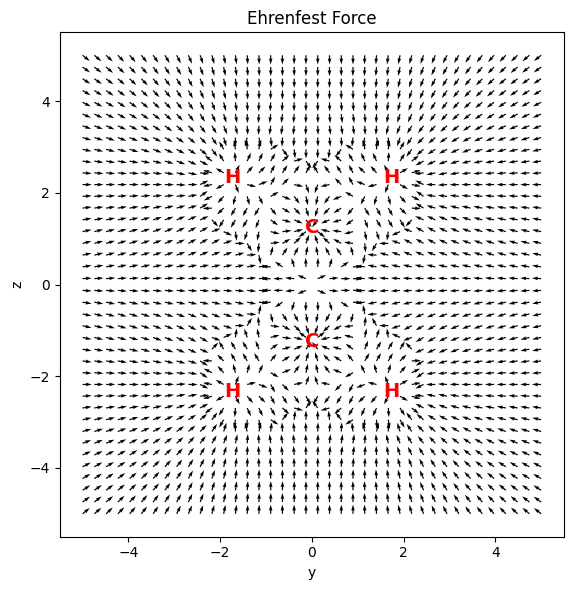

In [6]:
# use fixed length for the gradient vectors
grad_length = 0.2
ef_sc = ef_vals/np.linalg.norm(ef_vals, axis=1)[:, None] * grad_length

# plot the atoms boundaries (ef = 0)
fig=plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect='equal')
# Plot the electron density as contour plot
ax1.set_title("Ehrenfest Force")
ax1.set_xlabel("y")
ax1.set_ylabel("z")

X = points[:, 1].reshape(plt_pts, plt_pts)
Y = points[:, 2].reshape(plt_pts, plt_pts)
Z = np.zeros_like(X)

# Plot the vectorial map (omit the x-component)
ax1.quiver(points[:, 1], points[:, 2], ef_sc[:, 1], ef_sc[:, 2], color='k', angles='xy', scale_units='xy', scale=1)

# Add atomic symbols to the plots
symbols = ['C', 'H', 'H', 'C', 'H', 'H']
yz_coords = atcoords[:, 1:]
for coord, symbol in zip(yz_coords, symbols):
    ax1.text(coord[0], coord[1], symbol, color='red', ha='center', va='center', fontsize=14,fontweight='bold')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Ehrenfest Hessian
Another related quantity is the Ehrenfest Hessian, which is defined as the negative of the gradient of the Ehrenfest force:

$$
\begin{equation}
  \begin{split}
    H_{jk}(\mathbf{r}_n | \alpha, \beta)
    =&
    - \frac{\partial}{\partial r_k} F_j(\mathbf{r}_n | \alpha, \beta)\\
    =&
    \alpha
    \sum_i
    \left(
      \frac{\partial^4}{\partial r^2_i \partial r_k \partial r'_j} \gamma(\mathbf{r}, \mathbf{r}')
      +\frac{\partial^4}{\partial r^2_i \partial r'_j \partial r'_k} \gamma(\mathbf{r}, \mathbf{r}')
    \right)_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
    &- (1 - \alpha)
    \sum_i
    \left(
      \frac{\partial^4}{\partial r^2_i \partial r_j \partial r_k} \gamma(\mathbf{r}, \mathbf{r})
      + \frac{\partial^4}{\partial r^2_i \partial r_j \partial r'_k} \gamma(\mathbf{r}, \mathbf{r})
    \right)_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
    &- (1 - 2\alpha)
    \sum_i
    \left(
      \frac{\partial^4}{\partial r_i \partial r_j \partial r_k \partial r'_i} \gamma(\mathbf{r}, \mathbf{r})
      + \frac{\partial^4}{\partial r_i \partial r_j \partial r'_i \partial r'_k} \gamma(\mathbf{r}, \mathbf{r})
    \right)_{\mathbf{r} = \mathbf{r}' = \mathbf{r}_n}\\
    &+ \frac{1}{2} \sum_i \delta_{ij} \beta
    \frac{\partial^2}{\partial r_i \partial r_k} \nabla^2 \rho(\mathbf{r}_n)\\
  \end{split}
\end{equation}
$$


The following example shows how to evaluate it at a set of points.

In [7]:
from gbasis.evals.stress_tensor import evaluate_ehrenfest_hessian

# center of mass of ethylene
com = (np.mean(mol_data.atmasses[:,None] * atcoords, axis=0) / np.sum(mol_data.atmasses))[None,:]
print(f"Center of mass of ethylene: {com}", end="\n\n")

alpha, beta = 1, 0
print(f"Ehrenfest Hessian (α = {alpha} and β = {beta}):")
ef_com = evaluate_ehrenfest_hessian(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest Hessian at one point: {ef_com[0].shape}")
print(f"Ehrenfest Hessian at center of mass:\n{ef_com}")
print(f"Ehrenfest Hessian at center of mass is zero: {np.allclose(ef_com, 0)}", end="\n\n")
print(f" (should be zero)", end="\n\n")

alpha, beta = 0.5, 1
print("Ehrenfest Hessian  (α = 0.5 and β = 1):")
ef_com = evaluate_ehrenfest_hessian(rdm, ao_basis, com, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest Hessian at one point: {ef_com[0].shape}")
print(f"Ehrenfest Hessian at center of mass:\n{ef_com}")
print(f"Ehrenfest Hessian at center of mass is zero: {np.allclose(ef_com, 0)}", end="\n\n")

print(f"Ehrenfest Hessian evaluated at {points.shape[0]} points:")
ef_vals = evaluate_ehrenfest_hessian(rdm, ao_basis, points, alpha=alpha, beta=beta)
print(f"Shape of a Ehrenfest Hessian result: {ef_vals.shape}")

Center of mass of ethylene: [[ 5.03790449e-17  5.93301676e-18 -5.93301676e-18]]

Ehrenfest Hessian (α = 1 and β = 0):
Shape of a Ehrenfest Hessian at one point: (3, 3)
Ehrenfest Hessian at center of mass:
[[[ 3.13754990e-01  1.30439652e-16 -1.80258235e-15]
  [ 2.17535097e-16  1.15880193e+00  4.99817202e-17]
  [-7.05867199e-16  1.02321580e-16  1.56941145e+00]]]
Ehrenfest Hessian at center of mass is zero: False

 (should be zero)

Ehrenfest Hessian  (α = 0.5 and β = 1):
Shape of a Ehrenfest Hessian at one point: (3, 3)
Ehrenfest Hessian at center of mass:
[[[ 1.26822384e+00  2.96291708e-16  4.72803083e-15]
  [ 3.83387154e-16  2.98324460e+00  7.01565696e-16]
  [ 5.82474597e-15  7.53905556e-16 -1.36432043e+00]]]
Ehrenfest Hessian at center of mass is zero: False

Ehrenfest Hessian evaluated at 1600 points:
Shape of a Ehrenfest Hessian result: (1600, 3, 3)
